In [1]:
import numpy as np
import pandas as pd
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import polars as pl
import cv2
from IPython.display import Image, display
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical

#import face_recognition

In [12]:
data=pl.read_csv('labels.csv')

In [13]:
data

,pth,label,relFCs
i64,str,str,f64
0,"""anger/image0000006.jpg""","""surprise""",0.873142
1,"""anger/image0000060.jpg""","""anger""",0.852311
2,"""anger/image0000061.jpg""","""anger""",0.800957
3,"""anger/image0000066.jpg""","""disgust""",0.843079
4,"""anger/image0000106.jpg""","""anger""",0.849108
…,…,…,…
28170,"""surprise/image0034960.jpg""","""surprise""",0.825263
28171,"""surprise/image0034961.jpg""","""surprise""",0.738646
28172,"""surprise/image0034966.jpg""","""surprise""",0.774524


In [17]:
def image_show(i):
    row = data.row(i)
    pth = row[1]
    image_path = pth
    img = mpimg.imread(image_path)
    return img, row[2]

In [18]:
i=0
row = data.row(i)
pth = row[1]
image_path = pth
img = mpimg.imread(image_path)
# Check the shape of the image
height, width, channels = img.shape
print(f"Height - {height}", f", width - {height}",f", Color - {channels}")

#Color -3 means RGB, Color - 1 means Gray

Height - 96 , width - 96 , Color - 3


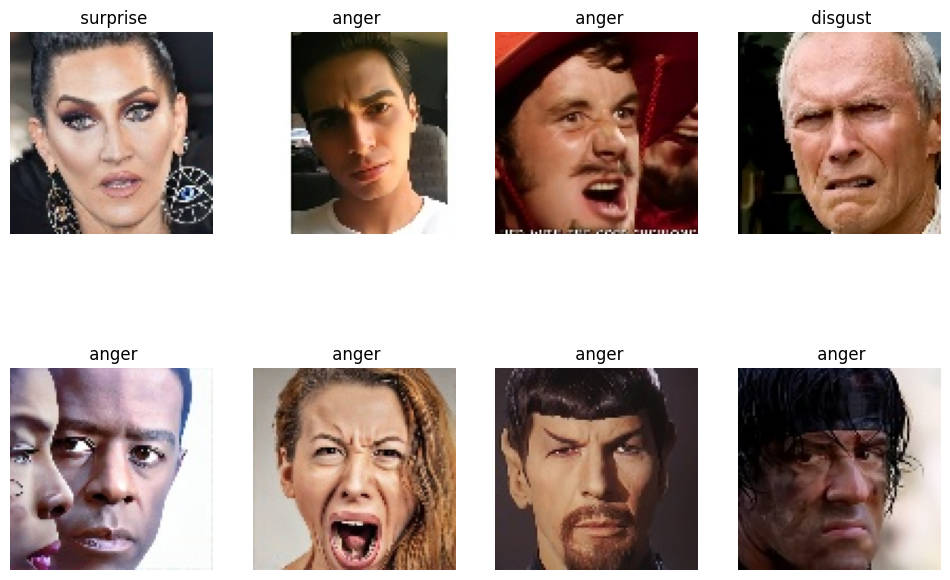

In [19]:
i=8
num_cols=int(i/2)
num_rows=int(i/num_cols)+i%2
fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 8))

for i in range(0,i):
    row = i // num_cols
    col = i % num_cols
    img_path,title=image_show(i)
    axes[row, col].imshow(img_path)
    axes[row, col].set_title(f' {title}')
    axes[row, col].axis('off')

Text(0.5, 1.0, 'Grey Image')

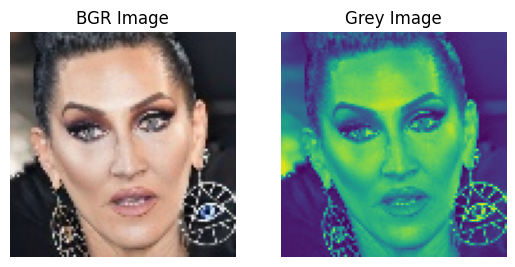

In [12]:
# Convert to grayscale
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Normalize pixel values to the range [0, 1]
img_normalized = img_gray / 255.0

# Now, img_normalized contains pixel values in the range [0, 1] as grayscale

# Display the BGR image
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.axis('off')
plt.title('BGR Image')

plt.subplot(1, 2, 2)
plt.imshow(img_normalized)
plt.axis('off')
plt.title('Grey Image')

In [ ]:
# Extract features (image paths) and labels
X = data['pth'].to_numpy()
y = data['label'].to_numpy()

In [13]:
def preprocess_image(image_path):
    img = cv2.imread(image_path)
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_resized = cv2.resize(img_gray, (96, 96))
    img_normalized = img_resized / 255.0
    return img_normalized


X_preprocessed=np.array([preprocess_image(image_path) for image_path in X])

# Labeling the data
le = LabelEncoder()
y_preprocessed = to_categorical(le.fit_transform(y))

In [14]:
from sklearn.model_selection import train_test_split

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_preprocessed, y_preprocessed, test_size=0.2, random_state=42, stratify=y)

In [17]:
input_shape=X_preprocessed[0].shape

input_shape

(96, 96)

In [19]:
from tensorflow.keras.utils import plot_model
from tensorflow.keras import models, layers
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten
import platform
from keras.optimizers import Adam

# create model structure
model = Sequential()

input_shape=(96, 96, 1)
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu',input_shape= input_shape))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
#Number of class
num_class= len(np.unique(y))
model.add(Dense(num_class, activation='softmax'))

# Compile the model

if 'M1' in platform.processor() or 'M2' in platform.processor():
    optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.001)
else:
    optimizer = Adam(learning_rate=0.001)
    
    
model.compile(optimizer=Adam(learning_rate=0.001), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [20]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 94, 94, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 92, 92, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 46, 46, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 46, 46, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 44, 44, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 22, 22, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 20, 20, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 10, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 10, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 12800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1024)           │    13,108,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 8)              │         8,200 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,356,680 (50.95 MB)

 Trainable params: 13,356,680 (50.95 MB)

 Non-trainable params: 0 (0.00 B)

In [21]:
num_epochs=20
batch_size=64
history = model.fit(X_train, y_train, epochs=num_epochs, batch_size=batch_size, validation_split=0.2)

Epoch 1/20
129/282 ━━━━━━━━━━━━━━━━━━━━ 2:14 881ms/step - accuracy: 0.1627 - loss: 2.0896

KeyboardInterrupt: 